In [24]:
import pandas as pd
import sqlite3
from pathlib import Path

In [25]:
db_path = Path("parlgov-development.db")
con = sqlite3.connect(db_path, detect_types=sqlite3.PARSE_DECLTYPES)
cur = con.cursor()

In [26]:
country_id = 41

In [27]:
df_election = pd.read_sql_query("SELECT id, date, seats_total FROM election WHERE country_id=? AND type_id=13 ORDER BY date DESC", con, params=(country_id,))
election_ids = tuple(df_election.get("id"))
election_ids
df_election["date"] = pd.to_datetime(df_election["date"], format="%Y-%m-%d")

In [28]:
qry= f'SELECT election_id, party_id, seats FROM election_result WHERE election_id IN ({",".join("?"*len(election_ids))})'
df_election_results = pd.read_sql_query(qry, con, params=election_ids)
#df_election_results

In [29]:
qry = f'SELECT party.id, party.name, viewcalc_party_position.left_right FROM party LEFT JOIN viewcalc_party_position ON party.id=viewcalc_party_position.party_id WHERE party.country_id=?'
df_party_left_right = pd.read_sql_query(qry, con, params=(country_id,))
#df_party_left_right

In [30]:
df_election_results = pd.merge(df_election_results, df_party_left_right, how="left", left_on="party_id", right_on="id")
#df_election_results



In [31]:
df_election_results["left_right_calc"] = df_election_results["seats"] * df_election_results["left_right"]
df_election_results = df_election_results.drop("id", axis=1)
#df_election_results

In [32]:


df_final = pd.merge(df_election, df_election_results, left_on="id", right_on="election_id")
df_final["left_right"] = df_final.groupby("id")["left_right_calc"].transform("sum") / df_final["seats_total"]
df_final = df_final[["id", "date", "seats_total", "left_right"]].drop_duplicates(["id"]).sort_values(["date"], ascending=False)
df_final["left_right"] = df_final["left_right"].round(2)
#df_final

In [33]:
df_final["previous_left_right"] = df_final['left_right'].shift(-1).fillna(df_final['left_right'])
df_final["left_right_difference"] = df_final['left_right'] - df_final["previous_left_right"]

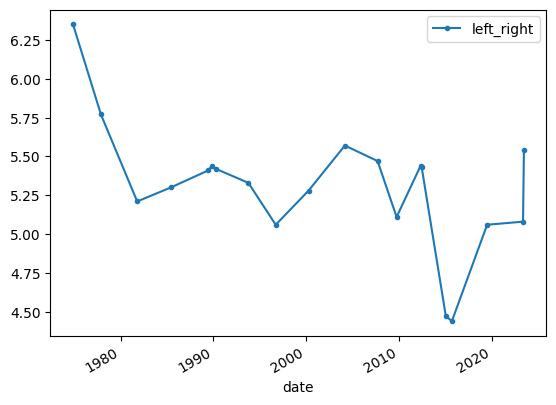

In [34]:
plot = df_final.sort_values(["date"]).plot(x="date", y="left_right", style=".-")

# for index, row in df_final.sort_values(["date"]).iterrows():
#     plot.annotate(row["left_right"], (row["date"], row["left_right"]), xytext=(5,0),textcoords='offset points')

